In [ ]:
# run following lines if cannot successfully import

# pip install spacy
# python -m spacy download en_core_web_lg
# pip install wordcloud

In [4]:
# import necessary package
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Plotting tools
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import math

# Creating a spaCy object
nlp = spacy.load('en_core_web_lg')

# Pre-processing

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# define lemmalization function
def lemmatization(texts):
    
    # initialize the output
    texts_out = []
    
    # for every title in title list, do lemmatization
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([word.lemma_ for word in doc]) 
    return texts_out

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def create_customized_sw_list():
    
    # use NER to customize stop words list 1
    stop_words_ner_list=[]

    for i in range(1321):
        doc = nlp(" ".join(titles_words_lemmatized[i]))
        for j in doc.ents:
            stop_words_ner_list.extend(str(j).split())

    print('number of stop words recognized by spacy: ', len(stop_words_ner_list))
    
    # set a list 2 of other words we don't want to include
    customized_sw = ["'s",'refinery','source','sinopec','unit','pdvsa','trader','nigeria','dangote','italy',
                    'total','jxtg','italy','petrochina','idemitsu','marathon','sannazzaro','pbf','korea','cosmo',
                    'ioc','crp','huizhou','cnooc','hainan','complex','repsol','shell','milazzo','isab','sarroch',
                    'chevron','augusta','exxonmobil','bp','dutch','rfcc','say','hydrocracker','adnoc','imo',
                    'ruwais','petronor','druzhba','coker','ramco','south','rhineland','petrochemical','liaoyang',
                    'eni','star','sannazzaro','omsk','belarus','feyzin','mozyr','bilbao','perni','aramco','russia',
                    'malaysia']
    print('number of stop words recognized manually: ', len(customized_sw))
    
    # append the list 2 to stop words list 1
    stop_words_ner_list.extend(customized_sw)

    # get the unique stop words list
    stop_words_ner_list_new = list(set(stop_words_ner_list))
    print('number of unique stop words: ', len(stop_words_ner_list_new))
    
    return stop_words_ner_list_new

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Remove customize stop words in title_after_lemma
def get_cleaned_title(texts):
    
    # get cleaned words without stop words
    titles_words_cleaned = [[word for word in sent if word not in stop_words_ner_list_new] for sent in texts]
    
    # get a list of string from nested list
    titles_words_cleaned_sent = []
    for item in titles_words_cleaned:
        titles_words_cleaned_sent.append(" ".join(item))
    
    return titles_words_cleaned_sent

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# main part

# import data
news = pd.read_csv('news_for_classification_final.csv')
titles  = news.title.values.tolist()

# break sentences to words
titles_words = list(sent_to_words(titles))

# get title after lemmatization
titles_words_lemmatized = lemmatization(titles_words)

# get customized stop words list
stop_words_ner_list_new = create_customized_sw_list()

# get final sentences for modelling
titles_words_cleaned_sent = get_cleaned_title(titles_words_lemmatized)
titles_words_cleaned_sent[:10]

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


number of stop words recognized by spacy:  594
number of stop words recognized manually:  62
number of unique stop words:  203


['mothball wilhelmshaven to restart',
 'successfully maintenance',
 'falconara plan work delay',
 'poland gdansk operator see margin rise on',
 'hopeful funding for cpcl expansion',
 'set to start work on cru relate',
 'venezuela to shut distiller no amuay due to fire',
 'start construction expansion project',
 'pemex to restart madero before',
 'bpcl to restart mumbai in']

In [37]:
len(titles_words_cleaned_sent)

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1321

# Training LDA model using sklearn

In [13]:
# get feature matrix
vectorizer = CountVectorizer(min_df=10, max_df=0.9, stop_words='english')
data_vectorized = vectorizer.fit_transform(titles_words_cleaned_sent)

# get lda model results
lda = LatentDirichletAllocation(n_components=6, learning_decay=0.9, verbose=True)
data_lda = lda.fit_transform(data_vectorized)

# get term names for further exploration
terms = vectorizer.get_feature_names()

# visualization using pyLDAvis
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')

# Save the output to the html file
pyLDAvis.save_html(dash, "topic_viz.html")

# evaluation of the model
print("Perplexity: ", lda.perplexity(data_vectorized))
print("Score: ", lda.score(data_vectorized))

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Perplexity:  80.32197491179343
Score:  -12430.046552607188


# Topic number choosing

In [11]:
# Define Search Param
search_params = {'n_components': [2, 6, 10, 14, 18], 'learning_decay': [.5, .7, .9]}

# Init the model
lda_multiple = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda_multiple, search_params)

model.fit(data_vectorized)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(data_vectorized))

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best model's params:  {'learning_decay': 0.5, 'n_components': 2}
Best log likelihood score:  -2661.8025179110437
Model perplexity:  70.85717991414926


C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

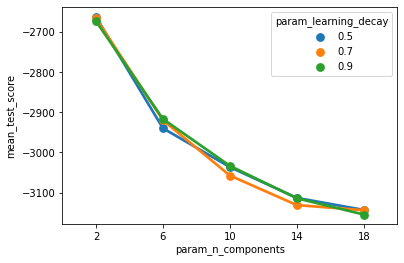

In [12]:
# plot
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.to_csv("LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

# Topic distribution

In [14]:
def get_dominant_topic(lda_output):
    
    # create a dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output,6), columns=topicnames, index=docnames)

    # dominant topic
    df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)

    return df_document_topic

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def get_tp_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    return df_topic_distribution

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Styling
def make_bold(val):
    weight = 700 if val > .2 else 400
    return 'font-weight: {weight}'.format(weight=weight)

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Create a document to topic matrix
lda_output = lda.transform(data_vectorized)

# column names
topicnames = ['Topic_' + str(i) for i in range(lda.n_components)]

# index names
docnames = ['Doc_' + str(i) for i in range(len(titles_words_cleaned_sent))]

df_document_topic = get_dominant_topic(lda_output)
df_document_topics = df_document_topic.head(15).style.applymap(make_bold)
df_document_topics

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df_topic_distribution = get_tp_distribution(df_document_topic)
df_topic_distribution

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic Num  Num Documents
0          4            315
1          0            281
2          1            204
3          2            195
4          5            178
5          3            148

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='dominant_topic', ylabel='count'>

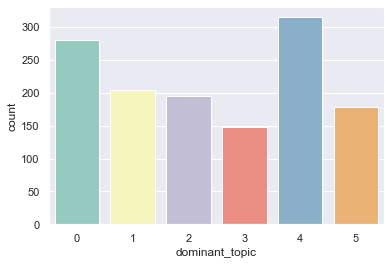

In [19]:
sns.set_theme(style="darkgrid")
sns.countplot(df_document_topic.dominant_topic, palette="Set3")

# Label ratio of each topic

In [57]:
def get_label_ratio():
    
    # init index list
    l = [[], [], [], [], [], []]
    
    # get the index list of each topic
    for i in range(len(titles_words_cleaned_sent)):
        l[df_document_topic['dominant_topic'][i]].append(i)
        
    # init label ratio list
    label_ratio = []
    
    # get the results
    for i in range(6):
        ratio = 0
        for j in range(len(l[i])):
            ratio += int(news.iloc[l[i][j]][3])
        ratio = ratio/len(l[i])
        label_ratio.append(ratio)
    
    # get the dataframe of the ratio
    d = {'topic num': [0,1,2,3,4,5]}
    label_ratio_res = pd.DataFrame(data = d)
    label_ratio_res['label ratio'] = label_ratio
    
    return label_ratio_res

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
label_res = get_label_ratio()
label_res

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic num  label ratio
0          0     0.494662
1          1     0.284314
2          2     0.405128
3          3     0.729730
4          4     0.825397
5          5     0.235955

# Topic keywords

In [20]:
def get_topic_keywords(lda_model, x, y):
    # Topic - Keyword matrix
    df_topic_keywords = pd.DataFrame(lda_model.components_)

    # assign column and index
    df_topic_keywords.columns = vectorizer.get_feature_names()
    df_topic_keywords.index = topicnames
    
    # select first x words in the first y rows to visualize
    df_topic_keywords_fxy = df_topic_keywords.iloc[:,:x].head(y).style.applymap(make_bold)
    return df_topic_keywords_fxy

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Show top n keywords for each topic
def show_topics(vectorizer = vectorizer, lda_model = lda, n_words = 15):
    
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    
    # Topic - Keywords Dataframe
    topic_keywords_top = pd.DataFrame(topic_keywords)
    topic_keywords_top.columns = ['Word '+str(i) for i in range(topic_keywords_top.shape[1])]
    topic_keywords_top.index = ['Topic '+str(i) for i in range(topic_keywords_top.shape[0])]
    
    return topic_keywords_top

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
df_topic_keywords = get_topic_keywords(lda, 10, 15)
df_topic_keywords

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
df_topic_keywords_top = show_topics()
df_topic_keywords_top

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Word 0    Word 1       Word 2      Word 3      Word 4    Word 5  \
Topic 0      restart      work        crude       carry         set     cargo   
Topic 1      upgrade       run         fuel  production        rate    output   
Topic 2        plant  capacity    operation     offline  processing    resume   
Topic 3         shut     flare  maintenance       power    shipment  contract   
Topic 4  maintenance      plan        start        work  turnaround  complete   
Topic 5       export    report      product         oil         new    gasoil   

           Word 6      Word 7    Word 8   Word 9   Word 10   Word 11  \
Topic 0    poland       phase  pipeline    rapid  underway    supply   
Topic 1  gasoline     project    report    delay  complete    reduce   
Topic 2    expect   expansion     union    stake   operate  facility   
Topic 3     close  throughput       oil  typhoon       apr   suspend   
Topic 4   restart       plant    strike  partial  shutdown   undergo   
Topic 5     raise         cut      halt   launch    energy       dec   

          Word 12   Word 13   Word 14  
Topic 0    repair   receive      sell  
Topic 1       jet      rise  increase  
Topic 2  refining    normal     flare  
Topic 3       mar      halt  beaumont  
Topic 4     begin      port     socar  
Topic 5     start  gasoline       aug

# Clustering

In [24]:
def cluster_tp(lda_output, n):
    # Construct the k-means clusters
    clusters = KMeans(n_clusters = n, random_state=100).fit_predict(lda_output)

    # Build the Singular Value Decomposition(SVD) model
    svd_model = TruncatedSVD(n_components=2)  # 2 components
    lda_output_svd = svd_model.fit_transform(lda_output)

    # X and Y axes of the plot using SVD decomposition
    x = lda_output_svd[:, 0]
    y = lda_output_svd[:, 1]

    # Weights for the 15 columns of lda_output, for each component
    print("Component's weights: \n", np.round(svd_model.components_, 2))

    # Percentage of total information in 'lda_output' explained by the two components
    print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))
    
    return x, y, clusters

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
def show_clusters(x, y, clusters):
    plt.figure(figsize=(12, 12))
    plt.scatter(x, y, c=clusters)
    plt.ylabel('Component 2')
    plt.xlabel('Component 1')
    plt.title("Segregation of Topic Clusters", )

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Component's weights: 
 [[ 0.39  0.36  0.33  0.27  0.64  0.36]
 [-0.26 -0.36 -0.24 -0.16  0.77 -0.36]]
Perc of Variance Explained: 
 [0.02 0.28]


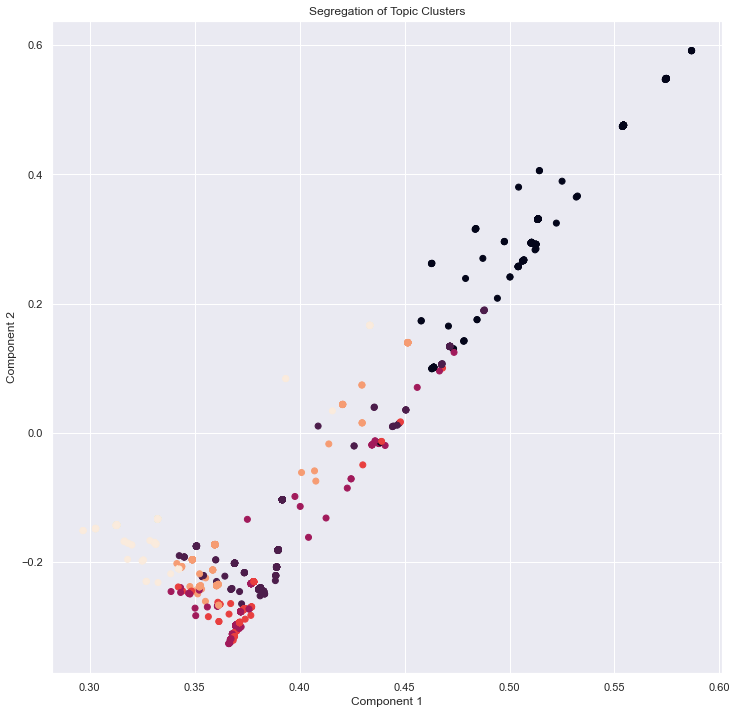

In [26]:
x, y, clusters = cluster_tp(lda_output, 6)
show_clusters(x, y, clusters)

# Word cloud

In [27]:
def get_topic_wc_list(n, lda):
    # declaring number of terms we need per topic
    terms_count = n

    # init topic word cloud list
    topic_wc = []
    
    for idx, topic in enumerate(lda.components_):
        
        # count top n words df for each topic
        abs_topic = abs(topic)
        topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
        topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
        topic_words = []
        
        # get the list
        for i in range(terms_count):
            topic_words.append(topic_terms_sorted[i][0])
        
        # initial df dictionary
        dict_word_frequency = {}
        
        # get the dictionary
        for i in range(terms_count):
            dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]
        
        # get dictionary for all topics
        topic_wc.append(dict_word_frequency)
    
    return topic_wc

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
def draw_wc(res):
    # init word cloud style
    wcloud = WordCloud(background_color="white", mask=None, max_words=100,\
                       max_font_size=60, min_font_size=10, prefer_horizontal=0.9,
                       contour_width=3, contour_color='black')
    
    # prepare plot in rows with 2 patterns per row
    n = len(res)
    cols = 2
    rows = math.ceil(n / cols)    
    fig, axes = plt.subplots(rows, cols, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = topic_wc[i]
        wcloud.generate_from_frequencies(topic_words)
        plt.gca().imshow(wcloud, interpolation='bilinear')
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    
    # cancel comment out the following line if want to export
    plt.savefig("Topic Results.png")
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\xiaol\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


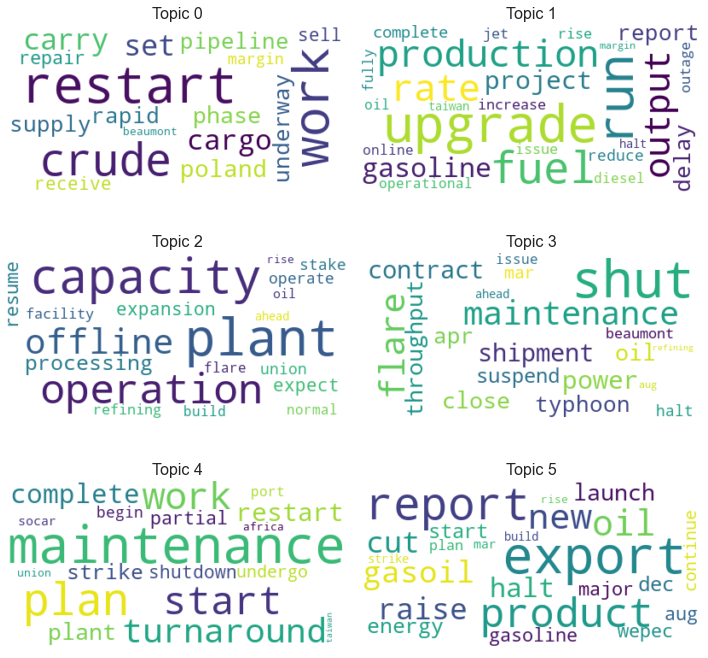

In [35]:
# get topic word cloud list
topic_wc = get_topic_wc_list(25, lda)

draw_wc(topic_wc)